In [6]:
import pandas as pd
import glob
import csv
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import collocations
from nltk import pos_tag as pos
from nltk.tokenize import word_tokenize
from gensim.utils import simple_preprocess
from gensim.corpora.dictionary import Dictionary
from gensim.corpora import MmCorpus
from gensim.models import LdaModel, LdaMulticore, CoherenceModel
import matplotlib.pyplot as plt
import pyLDAvis.gensim

In [2]:
# Import all CSV files from all Wiki articles and save them to one list
files = glob.glob("articles/*.csv")

all_articles = []

for file in files:
    read_handle = open(file, "r")
    text = list(csv.reader(read_handle, delimiter=","))        
    for article in text[1:]:
        all_articles.append(article[1])     

# How many articles has been read
print('Number of articles:', len(all_articles))

Number of articles: 488


In [4]:
all_tokens = []

# import stopwords
stop_words = stopwords.words('english')
wnl = WordNetLemmatizer()

for article in all_articles:
    # Removing section headers and new line breaks
    text = re.sub("==.*==",'', article)
    text = re.sub("\n",'', text)
    
    # Convert a document into a list of tokens 
    # This lowercases, tokenizes, removes numerical values
    tokens = simple_preprocess(text)
    
    doc_out = []
    for word in tokens:    
        if word not in stop_words:  # to remove stopwords
            Lemmatized_Word = wnl.lemmatize(word)  # lemmatize
            doc_out.append(Lemmatized_Word)
    
    all_tokens.append(doc_out)

# Print out infromation about articles and number of tokens for top 15
print('Tokens groups:', len(all_tokens),'\n')
print("{0:7}{1:10}".format("-No-","--Tokens--"))
for x, tokens in enumerate(all_tokens[:15]):
    print("{0:3}{1:10}".format(x + 1, len(tokens)))

Tokens groups: 488 

-No-   --Tokens--
  1       324
  2       737
  3       164
  4       238
  5       276
  6       162
  7       547
  8       172
  9       546
 10      1168
 11       324
 12       396
 13       386
 14        95
 15       298


## Bigrams & Trigrams
https://nicharuc.github.io/topic_modeling/

### Bigrams

In [43]:
bigram_measures = collocations.BigramAssocMeasures()

finder = collocations.BigramCollocationFinder.from_documents(all_tokens)

# Filter only those that occur at least N times
finder.apply_freq_filter(20)
bigram_scores = finder.score_ngrams(bigram_measures.pmi)

# Create a dataframe with bigram PMI scores -  Pointwise Mutual Information
# This measures how much more likely the words co-occur than if they were independent. 
# The metric is sensitive to rare combination of words, so it is used with an occurrence 
# frequency filter to ensure phrase relevance.
bigram_pmi = pd.DataFrame(bigram_scores)
bigram_pmi.columns = ['bigram', 'pmi']
bigram_pmi.sort_values(by='pmi', axis = 0, ascending = False, inplace = True)
print('Number of bigrams:',len(bigram_pmi.index))
bigram_pmi.head(25)

Number of bigrams: 277


,bigram,pmi
0,"(hong, kong)",12.838263
1,"(simon, schuster)",12.671039
2,"(planned, parenthood)",12.548756
3,"(cum, laude)",12.101297
4,"(magna, cum)",12.101297
5,"(leon, guerrero)",11.730871
6,"(silicon, valley)",11.568174
7,"(covid, pandemic)",11.441557
8,"(joe, biden)",11.401351
9,"(chamber, commerce)",11.330116


In [8]:
# Filter for bigrams with only noun-type structures
def bigram_filter(bigram):
    tag = pos(bigram)
    if tag[0][1] not in ['JJ', 'NN'] and tag[1][1] not in ['NN']:
        return False
    if bigram[0] in stop_words or bigram[1] in stop_words:
        return False
    if 'n' in bigram or 't' in bigram:
        return False
    if 'PRON' in bigram:
        return False
    return True

In [44]:
filtered_bigram = bigram_pmi[bigram_pmi.apply(lambda bigram:\
                                              bigram_filter(bigram['bigram'])\
                                              and bigram.pmi > 5, axis = 1)][:500]
print('Number of filtered bigrams:',len(filtered_bigram.index))
filtered_bigram.head()

Number of filtered bigrams: 180


,bigram,pmi
0,"(hong, kong)",12.838263
1,"(simon, schuster)",12.671039
2,"(planned, parenthood)",12.548756
4,"(magna, cum)",12.101297
5,"(leon, guerrero)",11.730871


In [12]:
# Joining bigrams
bigrams = [' '.join(x) for x in filtered_bigram.bigram.values if len(x[0]) > 2 or len(x[1]) > 2]
bigrams[:10]

['hewlett packard',
 'alma mater',
 'desmond hellmann',
 'hong kong',
 'ben ishay',
 'simon schuster',
 'von tobel',
 'planned parenthood',
 'phi beta',
 'douglas elliman']

### Trigrams

In [15]:
trigram_measures = collocations.TrigramAssocMeasures()
finder = collocations.TrigramCollocationFinder.from_documents(all_tokens)
# Filter only those that occur at least N times
finder.apply_freq_filter(10)
trigram_scores = finder.score_ngrams(trigram_measures.pmi)

# Trigram dataframe
trigram_pmi = pd.DataFrame(trigram_scores)
trigram_pmi.columns = ['trigram', 'pmi']
trigram_pmi.sort_values(by='pmi', axis = 0, ascending = False, inplace = True)
print('Number of trigrams:',len(trigram_pmi.index))
trigram_pmi.head()

Number of trigrams: 140


,trigram,pmi
0,"(buena, salud, guide)",25.723594
1,"(phi, beta, kappa)",25.454133
2,"(magna, cum, laude)",24.202595
3,"(robert, wood, johnson)",21.496690
4,"(graduated, magna, cum)",21.043672


In [20]:
# Filter for trigrams with only noun-type structures
def trigram_filter(trigram):
    tag = pos(trigram)
    if tag[0][1] not in ['JJ', 'NN'] and tag[1][1] not in ['JJ','NN']:
        return False
    if trigram[0] in stop_words or trigram[-1] in stop_words or trigram[1] in stop_words:
        return False
    if 'n' in trigram or 't' in trigram:
         return False
    if 'PRON' in trigram:
        return False
    return True 

In [21]:
filtered_trigram = trigram_pmi[trigram_pmi.apply(lambda trigram: \
                                                 trigram_filter(trigram['trigram'])\
                                                 and trigram.pmi > 5, axis = 1)]

print('Number of filtered trigrams:',len(filtered_trigram.index))
filtered_trigram.head()

Number of filtered trigrams: 136


,trigram,pmi
0,"(buena, salud, guide)",25.723594
1,"(phi, beta, kappa)",25.454133
2,"(magna, cum, laude)",24.202595
3,"(robert, wood, johnson)",21.496690
4,"(graduated, magna, cum)",21.043672


In [22]:
# Joining trigrams
trigrams = [' '.join(x) for x in filtered_trigram.trigram.values if len(x[0]) > 2 or len(x[1]) > 2 and len(x[2]) > 2]
trigrams[:10]

['buena salud guide',
 'phi beta kappa',
 'magna cum laude',
 'robert wood johnson',
 'graduated magna cum',
 'doctor humane letter',
 'current dollar term',
 'wall street journal',
 'boy girl club',
 'carnegie mellon university']

### Create corpus with n-grams and only nouns

In [23]:
# Concatenate n-grams
def replace_ngram(x):
    for gram in trigrams:
        x = x.replace(gram, '_'.join(gram.split()))
    for gram in bigrams:
        x = x.replace(gram, '_'.join(gram.split()))
    return x

In [30]:
# Combine all tokens into one string
clean_articles = [' '.join(x) for x in all_tokens]

# Remplace ngrams with underscore (_) versions
ngram_articles = [replace_ngram(x) for x in clean_articles]
#print(ngram_articles[0])

# tokenize
articles_w_ngrams = [word_tokenize(x) for x in ngram_articles]

In [48]:
# Filter for only nouns
def noun_only(x):
    pos_article = pos(x)
    filtered = [word[0] for word in pos_article if word[1] in ['NN']]
    # to filter both noun and verbs
    #filtered = [word[0] for word in pos_article if word[1] in ['NN','VB', 'VBD', 'VBG', 'VBN', 'VBZ']]
    return(filtered)

In [47]:
final_articles = [noun_only(x) for x in articles_w_ngrams]
#print(final_articles[0])

['dr',
 'anabel',
 'educator',
 'author',
 'work',
 'curriculum',
 'intelligence',
 'director',
 'center',
 'president',
 'ceo',
 'school',
 'dame',
 'university',
 'anabel',
 'lee',
 'officer',
 'descent',
 'brigham',
 'university',
 'psychology',
 'master',
 'education',
 'child',
 'development',
 'executive',
 'director',
 'center',
 'california',
 'science',
 'curriculum',
 'book',
 'intelligence',
 'matter',
 'iq',
 'mainstream',
 'school',
 'administrator',
 'teacher',
 'jensen',
 'joshua',
 'freedman',
 'marsha',
 'rideout',
 'school',
 'eq',
 'network',
 'non_profit',
 'education',
 'eq',
 'president',
 'program',
 'organization',
 'intelligence',
 'assessment',
 'sei',
 'youth',
 'version',
 'sei',
 'yv',
 'school',
 'synapse',
 'school',
 'stone',
 'mccown',
 'professor',
 'dame',
 'university',
 'california',
 'psychology',
 'graduate',
 'student',
 'department',
 'chair',
 'school',
 'college',
 'education',
 'advisor',
 'support',
 'center',
 'advisor',
 'education',
 'jen

## LDA Model

In [112]:
dictionary = Dictionary(final_articles)
dictionary.filter_extremes(no_below = 10, no_above = 0.8)
print('Dictionary length:', len(dictionary.keys()))

# 100 tokens by frequency for cleaned up dictionary
new_t_most_freq = dictionary.most_common(100)
print('Top 20 tokens by frequency\n')

num = 1
for t, f in new_t_most_freq[:20]:
    print(str(num) + '.', t, '-', f)
    num = num + 1
    
doc_term_matrix = [dictionary.doc2bow(doc) for doc in final_articles]

Dictionary length: 1268
Top 20 tokens by frequency

1. company - 1254
2. woman - 1227
3. university - 881
4. president - 866
5. year - 816
6. business - 796
7. ceo - 637
8. board - 631
9. school - 581
10. time - 548
11. member - 548
12. college - 473
13. director - 449
14. program - 444
15. foundation - 409
16. work - 390
17. book - 344
18. state - 343
19. executive - 332
20. family - 332


In [104]:
# Coherence evaluation
coherence = []
for k in range(5,26):
    print('Round: ' + str(k))
    Lda = LdaMulticore
    ldamodel = Lda(doc_term_matrix, num_topics=k, id2word = dictionary, passes=40, workers = 4,\
                   iterations=100, eval_every = None)
    
    cm = CoherenceModel(model=ldamodel, texts=final_articles,\
                        dictionary=dictionary, coherence='c_v')
    coherence.append((k,cm.get_coherence()))

Round: 5
Round: 6
Round: 7
Round: 8
Round: 9
Round: 10
Round: 11
Round: 12
Round: 13
Round: 14
Round: 15
Round: 16
Round: 17
Round: 18
Round: 19
Round: 20
Round: 21
Round: 22
Round: 23
Round: 24
Round: 25


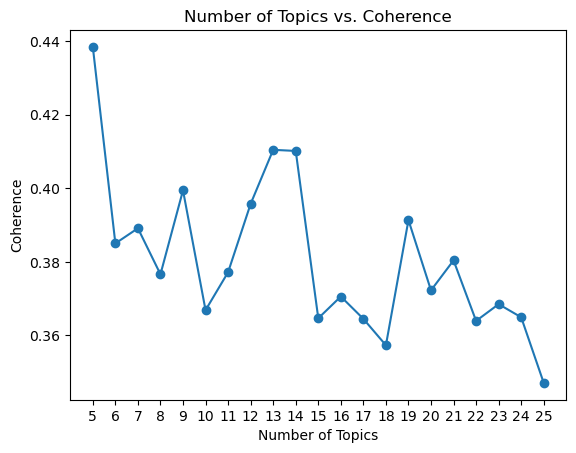

In [105]:
x_val = [x[0] for x in coherence]
y_val = [x[1] for x in coherence]

plt.plot(x_val,y_val)
plt.scatter(x_val,y_val)
plt.title('Number of Topics vs. Coherence')
plt.xlabel('Number of Topics')
plt.ylabel('Coherence')
plt.xticks(x_val)
plt.show()

In [113]:
# Tested for best setting
Lda = LdaMulticore
ldamodel = Lda(doc_term_matrix, num_topics = 13, id2word = dictionary, passes=40, workers = 4,\
               iterations=100, eval_every = None, random_state=0)

c_score = CoherenceModel(model = ldamodel, texts = final_articles, dictionary = dictionary, coherence = 'c_v')
print('LDA model coherence score is ', c_score.get_coherence())

# To show initial topics
ldamodel.show_topics(13, num_words=10, formatted=False)

[(0,
  [('film', 0.01581502),
   ('series', 0.01292505),
   ('role', 0.012322443),
   ('news', 0.011968789),
   ('medium', 0.011151779),
   ('television', 0.010431114),
   ('entertainment', 0.009512612),
   ('year', 0.008923908),
   ('part', 0.008499003),
   ('member', 0.008476269)]),
 (1,
  [('woman', 0.025870934),
   ('education', 0.019554164),
   ('school', 0.019423911),
   ('book', 0.015086467),
   ('art', 0.014508641),
   ('university', 0.013541526),
   ('museum', 0.01292512),
   ('year', 0.012340091),
   ('president', 0.011179454),
   ('child', 0.010773637)]),
 (2,
  [('woman', 0.029212357),
   ('university', 0.026019773),
   ('president', 0.024979794),
   ('board', 0.02325278),
   ('college', 0.01864312),
   ('member', 0.0176798),
   ('foundation', 0.016793625),
   ('director', 0.0154135),
   ('year', 0.013371059),
   ('school', 0.013004811)]),
 (3,
  [('health', 0.056262374),
   ('woman', 0.027928311),
   ('university', 0.025757773),
   ('center', 0.019393424),
   ('music', 0.0

In [118]:
c_score = CoherenceModel(model = ldamodel, texts = final_articles, dictionary = dictionary, coherence = 'c_v')
print('LDA model coherence score is ', c_score.get_coherence())

LDA model coherence score is  0.38467756225293004


In [106]:
Lda2 = LdaMulticore
ldamodel2 = Lda2(doc_term_matrix, num_topics = 5, id2word = dictionary, passes=40, workers = 4,\
               iterations=100, eval_every = None, random_state=0)

c_score2 = CoherenceModel(model = ldamodel2, texts = final_articles, dictionary = dictionary, coherence = 'c_v')
print('LDA model coherence score is ', c_score.get_coherence())

# To show initial topics
ldamodel2.show_topics(5, num_words=10, formatted=False)

[(0,
  [('research', 0.015993258),
   ('health', 0.015566217),
   ('college', 0.015079305),
   ('board', 0.014959406),
   ('science', 0.0128965145),
   ('system', 0.009721849),
   ('foundation', 0.009465599),
   ('director', 0.008688478),
   ('program', 0.008622943),
   ('service', 0.008594511)]),
 (1,
  [('film', 0.0195055),
   ('art', 0.019061254),
   ('medium', 0.013145074),
   ('television', 0.01310117),
   ('food', 0.012738485),
   ('director', 0.011796842),
   ('museum', 0.011142669),
   ('entertainment', 0.0111201545),
   ('program', 0.010584019),
   ('award', 0.009833151)]),
 (2,
  [('family', 0.013650614),
   ('education', 0.0125776585),
   ('child', 0.011775639),
   ('program', 0.01176603),
   ('foundation', 0.01112815),
   ('campaign', 0.010799556),
   ('book', 0.01054091),
   ('time', 0.010064953),
   ('work', 0.00983064),
   ('center', 0.00978803)]),
 (3,
  [('board', 0.025571778),
   ('director', 0.014806102),
   ('state', 0.014047881),
   ('position', 0.01202752),
   ('e

In [114]:
# Visualisation
topic_data =  pyLDAvis.gensim.prepare(ldamodel, doc_term_matrix, dictionary, mds = 'pcoa')
pyLDAvis.display(topic_data)

In [73]:
all_topics = {}
num_terms = 10 # Adjust number of words to represent each topic
lambd = 0.6 # Adjust this accordingly based on tuning above
for i in range(1,19): #Adjust this to reflect number of topics chosen for final LDA model
    topic = topic_data.topic_info[topic_data.topic_info.Category == 'Topic'+str(i)].copy()
    topic['relevance'] = topic['loglift']*(1-lambd)+topic['logprob']*lambd
    all_topics['Topic '+str(i)] = topic.sort_values(by='relevance', ascending=False).Term[:num_terms].values

In [75]:
pd.DataFrame(all_topics).T

,0,1,2,3,4,5,6,7,8,9
Topic 1,woman,board,ceo,president,business,university,member,company,management,executive
Topic 2,company,fiorina,mayer,business,time,hp,ceo,space,job,employee
Topic 3,conway,flournoy,longoria,campaign,trump,moskowitz,school,gonzalez,president,charter_school
Topic 4,mcnutt,britton,dylan,science,research,ganahl,first_avenue,oil,hiebert,radio
Topic 5,dushku,grann,colloff,gupta,cohen,dew,book,university,dornsife,turnbo
Topic 6,burn,dragas,fudge,board,glimcher,caputo,woman,colorado,ware,hirano
Topic 7,film,kardashian,county,hashimoto,finke,lauder,hollywood,district,kourtney,th_district
Topic 8,bush,museum,art,jarrett,laura_bush,desai,harnoncourt,claiborne,century,exhibition
Topic 9,jung,mcmahon,mcclintock,vernon,barrett,visram,company,vince,dubey,mitchell
Topic 10,mohr,hart,baker,messer,cisneros,mchale,carpenter,contee,dyson,ghosn


In [119]:
# Seemingly better model - needs installation
# https://radimrehurek.com/gensim_3.8.3/models/wrappers/ldamallet.html
# based on https://neptune.ai/blog/pyldavis-topic-modelling-exploration-tool-that-every-nlp-data-scientist-should-know

from gensim.models.wrappers import LdaMallet

ModuleNotFoundError: No module named 'gensim.models.wrappers'